In [1]:
from qtorch.quant import fixed_point_quantize, block_quantize, float_quantize

In [2]:
from qtorch import FloatingPoint

In [3]:
import pickle

In [77]:
import numpy as np
import fpzip
from pyzfp import compress, decompress
import torch
import matplotlib.pyplot as plt
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
from torch.nn.quantized.modules.utils import _quantize_weight
import pywt

In [6]:
from decentralizepy.compression.Elias8bitQuant import Elias8bitQuant
ebit8q = Elias8bitQuant()

In [7]:
a = np.random.normal(0, 0.1, 10000).astype(np.float32)

In [8]:
len(a)*4

40000

In [9]:
b = fpzip.compress(a , precision=12, order='C')

In [10]:
len(b)

12087

In [11]:
c = fpzip.decompress(b,  order='C')

In [12]:
c[0][0][0][0:10]

array([-0.01464844, -0.0859375 , -0.00268555,  0.01953125,  0.00317383,
       -0.078125  , -0.109375  ,  0.00585938, -0.1875    , -0.01464844],
      dtype=float32)

In [13]:
np.linalg.norm((a-c)[0][0], 2)

0.50458467

In [14]:
a

array([-0.01551323, -0.08976793, -0.00279709, ...,  0.0934156 ,
       -0.00322201, -0.16196491], dtype=float32)

In [15]:
at = torch.from_numpy(a)

In [16]:
stochastic_rounded = float_quantize(at, exp=3, man=5, rounding="stochastic")

In [17]:
float_quantize(torch.tensor(np.array([10]), dtype = torch.float32), exp=2, man=6, rounding="nearest").item()

7.9375

In [18]:
# something is off this should be half the size
# it is correct 2 bits can represent 0,1,2,3
# 3 - 1 = 2
# and 2^2 is 4
# They do no do subnormal numbers

In [19]:
fixed_point_quantize(torch.tensor(np.array([0.01]), dtype = torch.float32), 8, 7, rounding="nearest").item()

0.0078125

In [20]:
# there is 1 bit for sign

In [21]:
stochastic_rounded

tensor([-0.0156, -0.0859, -0.0078,  ...,  0.0938,  0.0000, -0.1641])

In [22]:
import numpy as np

In [23]:
stochastic_rounded

tensor([-0.0156, -0.0859, -0.0078,  ...,  0.0938,  0.0000, -0.1641])

In [24]:
bytes_array = stochastic_rounded.numpy().tobytes()

In [25]:
np.ndarray

numpy.ndarray

In [26]:
np.frombuffer(bytes_array, dtype = np.uint8)

array([  0,   0, 128, ...,   0,  40, 190], dtype=uint8)

In [27]:
len(pickle.dumps(stochastic_rounded))

40399

In [28]:
len(pickle.dumps(fpzip.compress(stochastic_rounded.numpy())))

36855

In [29]:
FloatingPoint(3,5)

FloatingPoint (exponent=3, mantissa=5)

In [30]:
len(pickle.dumps(at))

40399

In [31]:
len(pickle.dumps(fpzip.compress(at.numpy())))

37119

In [32]:
len(at)

10000

In [33]:
print(len(stochastic_rounded), stochastic_rounded.dtype)

10000 torch.float32


In [34]:
torch.norm(at - stochastic_rounded, 2)

tensor(0.3202)

In [35]:
#backend = 'fbgemm' if x86 else 'qnnpack'
#qconfig = torch.quantization.get_default_qconfig(backend)  
#torch.backends.quantized.engine = backend

In [36]:
torch.backends.quantized.engine

'fbgemm'

In [37]:
a = np.random.normal(0, 0.1, 10000).astype(np.float32)
scheme = torch.per_tensor_affine#per_tensor_affine # affine means taking into account the actual range of the values
observers = [MinMaxObserver(qscheme=scheme), MovingAverageMinMaxObserver(qscheme=scheme), HistogramObserver(qscheme=scheme)]
for obs in observers:
  #for x in inputs: obs(x) 
  obs.forward(torch.tensor(a))#(torch.tensor(a))
  print(obs.__class__.__name__, obs.calculate_qparams())

MinMaxObserver (tensor([0.0031]), tensor([123], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0031]), tensor([123], dtype=torch.int32))
HistogramObserver (tensor([0.0031]), tensor([123], dtype=torch.int32))


/home/jeffrey/anaconda3/envs/sacs39/lib/python3.9/site-packages/torch/ao/quantization/observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
/home/jeffrey/anaconda3/envs/sacs39/lib/python3.9/site-packages/torch/ao/quantization/observer.py:891: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_m

In [38]:
o = observers[0].calculate_qparams()

In [39]:
o

(tensor([0.0031]), tensor([123], dtype=torch.int32))

In [40]:
o[0]

tensor([0.0031])

In [41]:
aq = _quantize_weight(torch.tensor(a),  observers[2])

In [42]:
aq

tensor([ 0.0124,  0.0124, -0.0838,  ..., -0.0217, -0.1644,  0.0124],
       size=(10000,), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003101914655417204,
       zero_point=123)

In [43]:
torch.quantize_per_tensor(
            torch.tensor(a),
            o[0].item(), o[1].item(), torch.quint8)

tensor([ 0.0248,  0.0838, -0.0838,  ..., -0.0217, -0.1645,  0.1738],
       size=(10000,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003103430150076747,
       zero_point=123)

In [44]:
qt = torch.quantize_per_tensor(
            torch.tensor(a),
            o[0].item(), o[1].item(), torch.quint8)


In [45]:
qscheme=torch.qint8

In [46]:
aq

tensor([ 0.0124,  0.0124, -0.0838,  ..., -0.0217, -0.1644,  0.0124],
       size=(10000,), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003101914655417204,
       zero_point=123)

In [47]:
aq.q_scale()

0.003101914655417204

In [48]:
aq.q_zero_point()

123

In [49]:
aq.int_repr().max()

tensor(127, dtype=torch.int8)

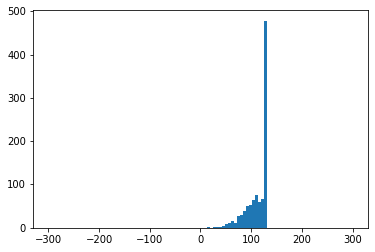

In [50]:
_ = plt.hist(aq.int_repr().to(torch.float32).numpy()[0:1000], 100, (-300, 300))

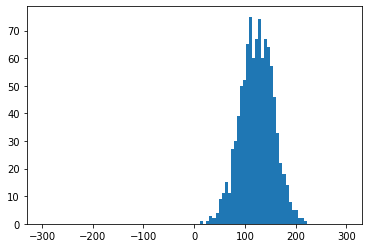

In [51]:
_ = plt.hist(qt.int_repr().to(torch.float32).numpy()[0:1000], 100, (-300, 300))

In [52]:
def convert(aq):
    return (aq.int_repr().to(torch.float32) - aq.q_zero_point())*aq.q_scale()

In [53]:
print(aq)

tensor([ 0.0124,  0.0124, -0.0838,  ..., -0.0217, -0.1644,  0.0124],
       size=(10000,), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.003101914655417204,
       zero_point=123)


In [54]:
convert(aq)

tensor([ 0.0124,  0.0124, -0.0838,  ..., -0.0217, -0.1644,  0.0124])

In [55]:
aq.int_repr()

tensor([127, 127,  96,  ..., 116,  70, 127], dtype=torch.int8)

In [56]:
a = np.random.rand(100).astype(np.float32)
at = torch.from_numpy(a)
scheme = torch.per_tensor_affine
observer = MovingAverageMinMaxObserver(qscheme=scheme) #MinMaxObserver, MovingAverageMinMaxObserver(qscheme=scheme), HistogramObserver(qscheme=scheme)]
observer.forward(at)
o = observer.calculate_qparams()
aq = torch.quantize_per_tensor(
    torch.tensor(a),
    o[0].item(), o[1].item(), torch.quint8)

In [57]:
torch.norm(at - convert(aq), 2).item()

0.010789979249238968

In [58]:
comp = ebit8q.compress_float(a)

In [59]:
decomp = ebit8q.decompress_float(comp)

In [60]:
torch.norm(at - decomp, 2).item()

0.010789979249238968

In [110]:
def comp(a):
    b = fpzip.compress(a , precision=14, order='C')
    c = fpzip.decompress(b,  order='C')
    bb = compress(a, tolerance=0.001, parallel=False)
    cc = decompress(bb, a.shape, a.dtype, tolerance=0.001)
    
    at = torch.from_numpy(a)
    stochastic_rounded = float_quantize(at, exp=5, man=2, rounding="stochastic")
    
    scheme = torch.per_tensor_affine#per_tensor_affine # affine means taking into account the actual range of the values
    observer = MovingAverageMinMaxObserver(qscheme=scheme) #MinMaxObserver, MovingAverageMinMaxObserver(qscheme=scheme), HistogramObserver(qscheme=scheme)]
    observer.forward(at)
    o = observer.calculate_qparams()
    # or observer(at)
    #aq = _quantize_weight(at,  observer), this method does not work well!
    aq = torch.quantize_per_tensor(
            torch.tensor(a),
            o[0].item(), o[1].item(), torch.quint8)
    print(a[0:10], aq[0:10])
    print(np.linalg.norm((a-c)[0][0], 2), np.linalg.norm((a-cc), 2), torch.norm(at - stochastic_rounded, 2).item(), torch.norm(at - convert(aq), 2).item())
    print("compression_ratio:", len(b)/(len(a)*4), len(bb)/(len(a)*4), 0.25, 0.25)
    return aq

In [102]:
def flatten_model(state_dict):
    shapes = []
    lens = []
    tensors_to_cat = []
    for _, v in state_dict.items():
        shapes.append(v.shape)
        t = v.flatten()
        lens.append(t.shape[0])
        tensors_to_cat.append(t)
    return torch.cat(tensors_to_cat)

In [103]:
a = np.random.rand(100).astype(np.float32)

In [104]:
a[0:10]

array([0.14649276, 0.8268811 , 0.07076293, 0.41617852, 0.535295  ,
       0.09393147, 0.4459402 , 0.97720236, 0.58554167, 0.3981123 ],
      dtype=float32)

In [105]:
qt = comp(a)

[0.14649276 0.8268811  0.07076293 0.41617852 0.535295   0.09393147
 0.4459402  0.97720236 0.58554167 0.3981123 ] tensor([0.1465, 0.8287, 0.0694, 0.4163, 0.5357, 0.0925, 0.4471, 0.9790, 0.5858,
        0.3970], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0038542263209819794,
       zero_point=0)
0.06702854 0.006093391 0.3343985676765442 0.011288280598819256
compression_ratio: 0.3525 0.42 0.25 0.25


In [89]:
def comp16(a):
    b = fpzip.compress(a , precision=18, order='C')
    c = fpzip.decompress(b,  order='C')
    
    at = torch.from_numpy(a)
    stochastic_rounded = float_quantize(at, exp=5, man=2, rounding="stochastic")
    
    scheme = torch.per_tensor_affine#per_tensor_affine # affine means taking into account the actual range of the values
    observer = MovingAverageMinMaxObserver(qscheme=scheme) #MinMaxObserver, MovingAverageMinMaxObserver(qscheme=scheme), HistogramObserver(qscheme=scheme)]
    observer.forward(at)
    o = observer.calculate_qparams()
    # or observer(at)
    #aq = _quantize_weight(at,  observer), this method does not work well!
    aq = torch.quantize_per_tensor(
            torch.tensor(a),
            o[0].item(), o[1].item(), torch.quint8)
    print(a[0:10], aq[0:10])
    print(np.linalg.norm((a-c)[0][0], 2), torch.norm(at - stochastic_rounded, 2).item(), torch.norm(at - convert(aq), 2).item())
    print("compression_ratio:", len(b)/(len(a)*4), 0.25, 0.25)
    return aq

In [90]:
qt = comp16(a.astype(np.float16))

ValueError: Data type float16 must be a floating type.

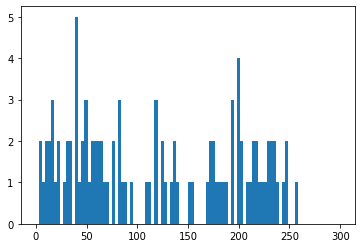

In [91]:
_ = plt.hist(qt.int_repr().to(torch.float32).numpy(), 100, (0, 300))

In [121]:
a = (np.random.rand(10000).astype(np.float32) -0.5) *10

In [122]:
a[0:10]

array([-4.3329406 ,  2.0941095 , -0.43923616,  0.24154782,  3.528521  ,
       -2.766264  , -0.47501475,  0.7699454 ,  0.90143025, -4.2246346 ],
      dtype=float32)

In [123]:
qt = comp(a)

[-4.3329406   2.0941095  -0.43923616  0.24154782  3.528521   -2.766264
 -0.47501475  0.7699454   0.90143025 -4.2246346 ] tensor([-4.3515,  2.0778, -0.4312,  0.2352,  3.5283, -2.7834, -0.4704,  0.7841,
         0.9017, -4.2339], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.039202895015478134,
       zero_point=127)
4.052173 0.016632441 23.100893020629883 1.1358001232147217
compression_ratio: 0.3867 0.5506 0.25 0.25


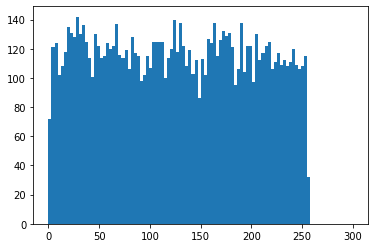

In [95]:
_ = plt.hist(qt.int_repr().to(torch.float32).numpy(), 100, (0, 300))

In [96]:
a = np.random.normal(0, 0.1, 10000).astype(np.float32)
qt = comp(a)

[-0.17422378 -0.17071381  0.00554137 -0.02331001  0.03649271  0.08106142
  0.05222103 -0.13010341 -0.16420947  0.04394973] tensor([-0.1739, -0.1712,  0.0054, -0.0245,  0.0353,  0.0815,  0.0516, -0.1304,
        -0.1630,  0.0435], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0027172896079719067,
       zero_point=126)
0.1308374 0.1322985 0.7414445281028748 0.07875864207744598
compression_ratio: 0.3656 0.302 0.25 0.25


In [112]:
    bb = compress(a, tolerance=0.001, parallel=False)
    cc = decompress(bb, a.shape, a.dtype, tolerance=0.001)

In [119]:
    cc = decompress(np.array(bb).tobytes(), a.shape, a.dtype, tolerance=0.001)

In [120]:
cc

array([0.14685059, 0.8272705 , 0.07067871, 0.4161377 , 0.5352783 ,
       0.09411621, 0.44592285, 0.977417  , 0.58569336, 0.39819336,
       0.6730957 , 0.03930664, 0.45550537, 0.75909424, 0.93377686,
       0.59088135, 0.03643799, 0.9828491 , 0.35211182, 0.24383545,
       0.01055908, 0.00189209, 0.13970947, 0.24627686, 0.06787109,
       0.74121094, 0.5839844 , 0.87353516, 0.39404297, 0.55029297,
       0.5673828 , 0.28515625, 0.46887207, 0.90270996, 0.7393799 ,
       0.7327881 , 0.19091797, 0.87109375, 0.04248047, 0.5761719 ,
       0.42425537, 0.21954346, 0.9767456 , 0.04937744, 0.708313  ,
       0.05804443, 0.62750244, 0.51239014, 0.8782959 , 0.18518066,
       0.6590576 , 0.48742676, 0.12817383, 0.42944336, 0.7199707 ,
       0.92163086, 0.24468994, 0.8966675 , 0.3772583 , 0.7821655 ,
       0.9729614 , 0.96136475, 0.41363525, 0.5739136 , 0.7182617 ,
       0.5683594 , 0.12109375, 0.89990234, 0.29241943, 0.01593018,
       0.19989014, 0.2798462 , 0.49334717, 0.31988525, 0.22454

In [116]:
len(np.array(bb).tobytes())

192

In [118]:
len(bb)

192

In [117]:
len(a.tobytes())

400

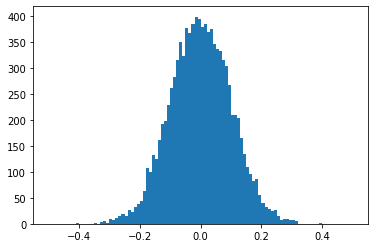

In [49]:
_ = plt.hist(a, 100, (-0.5,0.5))

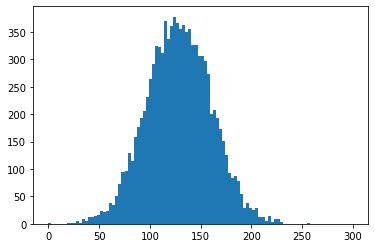

In [50]:
_ = plt.hist(qt.int_repr().to(torch.float32).numpy(), 100, (0, 300))

In [97]:
import torchvision

In [98]:
r18 = torchvision.models.resnet18(True)

In [99]:
flat = flatten_model(r18.state_dict())

In [111]:
comp(flat.numpy())

[-0.01041935 -0.00613561 -0.00180978  0.07484142  0.05661485  0.01708333
 -0.01269388  0.01108271  0.00952757 -0.10992692] tensor([ 0.0000,  0.0000,  0.0000,  0.0652,  0.0652,  0.0000,  0.0000,  0.0000,
         0.0000, -0.1305], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.06523405760526657,
       zero_point=45)
1.3827991 0.5653769 7.915776252746582 52.67439651489258
compression_ratio: 0.3207514668609603 0.3097713573964291 0.25 0.25


tensor([0., 0., 0.,  ..., 0., 0., 0.], size=(11699132,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.06523405760526657,
       zero_point=45)

In [547]:
def comp2(a):
    b = fpzip.compress(a , precision=12, order='C')
    c = fpzip.decompress(b,  order='C')
    
    at = torch.from_numpy(a)
    stochastic_rounded = float_quantize(at, exp=5, man=2, rounding="stochastic")
    
    scheme = torch.per_tensor_symmetric#per_tensor_affine # affine means taking into account the actual range of the values
    observer = HistogramObserver(qscheme=scheme) #MinMaxObserver, MovingAverageMinMaxObserver(qscheme=scheme), HistogramObserver(qscheme=scheme)]
    observer.forward(at)
    o = observer.calculate_qparams()
    # or observer(at)
    #aq = _quantize_weight(at,  observer), this method does not work well!
    aq = torch.quantize_per_tensor(
            torch.tensor(a),
            o[0].item(), o[1].item(), torch.quint8)
    print(a[0:10], aq[0:10])
    print(np.linalg.norm((a-c)[0][0], 2), torch.norm(at - stochastic_rounded, 2).item(), torch.norm(at - convert(aq), 2).item())
    print("compression_ratio:", len(b)/(len(a)*4), 0.25, 0.25)

In [468]:
comp2(flat.numpy())

[-0.01041935 -0.00613561 -0.00180978  0.07484142  0.05661485  0.01708333
 -0.01269388  0.01108271  0.00952757 -0.10992692] tensor([-0.0130,  0.0000,  0.0000,  0.0780,  0.0520,  0.0130, -0.0130,  0.0130,
         0.0130, -0.1040], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.013002387247979641,
       zero_point=128)
5.376652 7.8146185874938965 28.545759201049805
compression_ratio: 0.2583094839856495 0.25 0.25


In [474]:
len(flat)

11699132

In [469]:
flat.max()

tensor(13.7179)

In [470]:
flat.min()

tensor(-2.9168)

In [471]:
# these are the reasons why it is not working

In [476]:
len(flat[flat > 1])

580

In [ ]:
# Implement qint compression sceme where we ignore values > 1 by sending them seperately

In [556]:
flat2 = flat[(flat < 0.2)]

In [557]:
flat3 = flat2[flat2 > -0.2]

In [106]:
qt = comp(flat3.numpy())

NameError: name 'flat3' is not defined

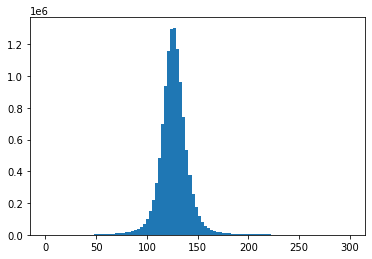

In [559]:
_ = plt.hist(qt.int_repr().to(torch.float32).numpy(), 100, (0, 300))

In [548]:
comp2(flat3.numpy())

[-0.01041935 -0.00613561 -0.00180978  0.07484142  0.05661485  0.01708333
 -0.01269388  0.01108271  0.00952757 -0.10992692] tensor([-0.0112, -0.0056,  0.0000,  0.0730,  0.0561,  0.0168, -0.0112,  0.0112,
         0.0112, -0.1123], size=(10,), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.005614420399069786,
       zero_point=128)
4.759155 6.922706604003906 5.910922527313232
compression_ratio: 0.2583142617722315 0.25 0.25


In [ ]:
# need non linear quantization

In [9]:
import pywt

In [56]:
# removing bn layers

In [13]:
resw = r18.state_dict()

In [14]:
resw = {k:v for k,v in resw.items() if "bn1." not in k}
resw = {k:v for k,v in resw.items() if "bn2." not in k}
resw = {k:v for k,v in resw.items() if len(v.shape) >1}

In [15]:
# Random
probs = torch.rand_like(flat)
indices = probs < 0.1
top10_og = torch.zeros(len(flat))
top10_og[indices] = flat[indices]
torch.norm(top10_og - flat, 2) 

tensor(102.5824)

In [ ]:
# Random
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    probs = torch.rand_like(torch.from_numpy(array))
    indices = probs < 0.1
    
    top10 = torch.zeros(len(array))
    top10[indices] = torch.from_numpy(array[indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 102.74525451660156 185069.125
db1 103.23194122314453 185122.640625
sym2 103.66918182373047 184979.96875
coif1 102.05806732177734 184744.890625
bior1.1 102.97911834716797 185177.625
rbio1.1 103.00313568115234 185171.53125


In [24]:
topk_og = torch.topk(
            flat.abs(), round(0.33*len(flat)), dim=0, sorted=False
        )
top10_og = torch.zeros(len(flat))
top10_og[topk_og.indices] = flat[topk_og.indices]
torch.norm(top10_og - flat, 2) 

tensor(25.6738)

In [25]:
print(flat.shape)

torch.Size([11699132])


In [23]:
# Base case on flattened data, with level=4
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2']#, 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.33*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 20.19877052307129 53562.796875
db1 20.19877052307129 53562.796875
sym2 20.11495018005371 53570.296875
min:  tensor(20.1150) sym2 2


In [22]:
# RMSE
import math
wv = math.sqrt(42.6776)
tpk =  math.sqrt(47.3773)
wv / tpk
# --> 0.949 --> 5% less error

0.9491062664912424

In [27]:
wv = math.sqrt(20.1150)
tpk =  math.sqrt(25.6738)
wv / tpk
# --> 0.88 --> 12% less error


0.8851460621415522

In [58]:
# level 4: 42.677608489990234 114424.265625
# None: 42.69436264038086 114436.171875

In [59]:
approx = coeff[0]
details = coeff[1:]

In [60]:
approx

array([-0.02112804, -0.12861666,  0.355115  , ...,  0.01942001,
        0.00414812, -0.02489999], dtype=float32)

In [61]:
len(flat) / 16

731195.75

In [62]:
len(approx)

731198

In [63]:
print(approx.max(), approx.min(), approx.mean())

16.845043 -5.0946984 -0.00447843


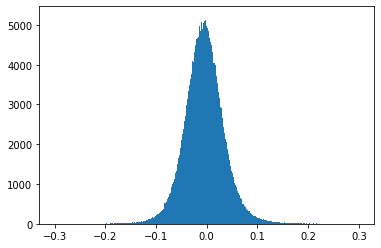

In [64]:
_ = plt.hist(approx, 1000, (-0.3, 0.3))

In [65]:
len(details)

4

In [66]:
print([len(d) for d in details])

[731198, 1462394, 2924785, 5849567]


In [67]:
d0 = details[0]

In [68]:
print(d0.max(), d0.min(), d0.mean())

4.3342423 -3.6128068 -5.1483516e-06


In [69]:
d0

array([-0.02881567, -0.49651563, -0.06628633, ...,  0.02382721,
       -0.02910749,  0.01628537], dtype=float32)

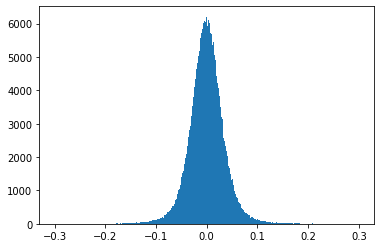

In [70]:
_ = plt.hist(d0, 1000, (-0.3, 0.3))

In [78]:
# Just using the approximation!
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2']#, 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
    approx = coeff[0]
    details = coeff[1:]
    details = [np.zeros_like(d) for d in details]
    approx_only = [approx]
    approx_only.extend(details)
    array, coeff_slices = pywt.coeffs_to_array(approx_only)
    #print(coeff_slices) # should be static so we do not need to send them
    #topk = torch.topk(
     #       torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
      #  )
    #top10 = torch.zeros(len(array))
    #top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(array, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 83.8722915649414 171346.921875
db1 83.8722915649414 171346.921875
sym2 83.61727142333984 169984.34375
min:  tensor(83.6173) sym2 2


In [23]:
array[topk.indices].max()

18.828228

In [24]:
array[topk.indices].min()

-9.629911

In [31]:
sub = array[topk.indices]

In [34]:
len(sub[np.absolute(sub) > 1])

527

In [35]:
len(sub)

1169917

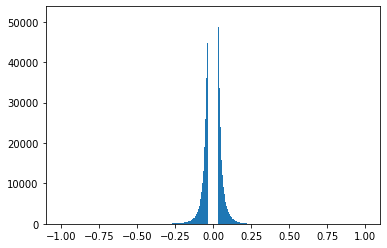

In [37]:
_ = plt.hist(array[topk.indices], 1000, (-1, 1))

In [171]:
len(flat)

11699132

In [172]:
np.sqrt(len(flat))

3420.399391883936

In [181]:
prime_factors(len(flat))

[2, 2, 191, 15313]

In [182]:
2*2*191

764

In [183]:
square = flat.reshape(764, 15313)

In [225]:
# Base case on rectangular data, with level=4
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedecn(square.numpy(), wavelet, level = 4)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    shape = array.shape
    print(shape)
    array = torch.from_numpy(array).flatten()
    topk = torch.topk(
            array.abs(), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    
    top10[topk.indices] = array[topk.indices]
    top10 = top10.reshape(shape).numpy()
    print(top10.shape)
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedecn")
    reverse_top10 = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet))
    reverse_top10 = reverse_top10[0:, :-1]
    print(reverse_top10.shape)
    err = torch.norm(reverse_top10 - square, 2)
    err1 = torch.norm(reverse_top10 - square, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

(765, 15317)
(765, 15317)
torch.Size([764, 15313])
haar 46.458038330078125 125166.609375
(765, 15317)
(765, 15317)
torch.Size([764, 15313])
db1 46.458038330078125 125166.609375
(774, 15322)
(774, 15322)
torch.Size([764, 15313])
sym2 46.43218231201172 125249.15625
(781, 15331)
(781, 15331)
torch.Size([764, 15313])
coif1 46.54570388793945 125596.46875
(765, 15317)
(765, 15317)
torch.Size([764, 15313])
bior1.1 46.458038330078125 125166.609375
(765, 15317)
(765, 15317)
torch.Size([764, 15313])
rbio1.1 46.458038330078125 125166.609375
(1004, 15556)
(1004, 15556)
torch.Size([764, 15313])
dmey 52.37420654296875 139893.703125
(798, 15348)
(798, 15348)
torch.Size([764, 15313])
bior4.4 47.59955978393555 128068.578125
min:  tensor(46.4322) sym2 2


In [75]:
# layerwise

In [29]:
stats = {k: l.shape  for k,l in resw.items()}

In [30]:
stats

{'conv1.weight': torch.Size([64, 3, 7, 7]),
 'layer1.0.conv1.weight': torch.Size([64, 64, 3, 3]),
 'layer1.0.conv2.weight': torch.Size([64, 64, 3, 3]),
 'layer1.1.conv1.weight': torch.Size([64, 64, 3, 3]),
 'layer1.1.conv2.weight': torch.Size([64, 64, 3, 3]),
 'layer2.0.conv1.weight': torch.Size([128, 64, 3, 3]),
 'layer2.0.conv2.weight': torch.Size([128, 128, 3, 3]),
 'layer2.0.downsample.0.weight': torch.Size([128, 64, 1, 1]),
 'layer2.1.conv1.weight': torch.Size([128, 128, 3, 3]),
 'layer2.1.conv2.weight': torch.Size([128, 128, 3, 3]),
 'layer3.0.conv1.weight': torch.Size([256, 128, 3, 3]),
 'layer3.0.conv2.weight': torch.Size([256, 256, 3, 3]),
 'layer3.0.downsample.0.weight': torch.Size([256, 128, 1, 1]),
 'layer3.1.conv1.weight': torch.Size([256, 256, 3, 3]),
 'layer3.1.conv2.weight': torch.Size([256, 256, 3, 3]),
 'layer4.0.conv1.weight': torch.Size([512, 256, 3, 3]),
 'layer4.0.conv2.weight': torch.Size([512, 512, 3, 3]),
 'layer4.0.downsample.0.weight': torch.Size([512, 256, 1

In [78]:
#r18.state_dict()['conv1.weight']

In [79]:
r18.state_dict()['conv1.weight'].shape

torch.Size([64, 3, 7, 7])

In [596]:
res = pywt.wavedec(r18.state_dict()['conv1.weight'].numpy(), "sym2")

In [597]:
res[1].shape

(64, 3, 7, 5)

In [598]:
res[0].shape

(64, 3, 7, 5)

In [600]:
test_weight = r18.state_dict()['conv1.weight'].numpy()

In [602]:
flatten_model({"f1": r18.state_dict()['conv1.weight']})

tensor([-0.0104, -0.0061, -0.0018,  ..., -0.0244, -0.0712, -0.0668])

In [605]:
flat_v1w = flatten_model({"f1": r18.state_dict()['conv1.weight']}).numpy()

In [630]:
# resw["bn1.num_batches_tracked"].shape

torch.Size([])

In [25]:
# wavedecn, with level = 0
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
            
        coeff = pywt.wavedecn(torch.squeeze(v).numpy(), wavelet, level = 0)
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedecn")
        state_dict[key] = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet))
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    flat = flatten_model(resw)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 47.194419860839844 124593.125
db1 47.194419860839844 124593.125
sym2 47.194419860839844 124593.125
coif1 47.194419860839844 124593.125
bior1.1 47.194419860839844 124593.125
rbio1.1 47.194419860839844 124593.125
dmey 47.194419860839844 124593.125
bior4.4 47.194419860839844 124593.125
min:  tensor(47.1944) haar 0


In [110]:
shape

[(64, 3, 7, 7),
 (64, 64, 3, 3),
 (64, 64, 3, 3),
 (64, 64, 3, 3),
 (64, 64, 3, 3),
 (128, 64, 3, 3),
 (128, 128, 3, 3),
 (128, 64),
 (128, 128, 3, 3),
 (128, 128, 3, 3),
 (256, 128, 3, 3),
 (256, 256, 3, 3),
 (256, 128),
 (256, 256, 3, 3),
 (256, 256, 3, 3),
 (512, 256, 3, 3),
 (512, 512, 3, 3),
 (512, 256),
 (512, 512, 3, 3),
 (512, 512, 3, 3),
 (1000, 512)]

## wavedecn does not work corretly for dim > 2, so we need to reshape

In [152]:
resw_oe = resw.copy()


In [153]:
del resw_oe["conv1.weight"] # for this one the size is incorrect during reconstruction

In [227]:
# wavedecn with axes specified, on dimensions reduced to 2x2
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw_oe.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
        v = torch.squeeze(v).numpy()
        if len(v.shape) > 2:
            #print(v.shape)
            v = v.reshape((v.shape[0], np.prod(v.shape[1:])))
            #print(v.shape)
        coeff = pywt.wavedecn(v, wavelet, level = None, axes = (0,1))
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff, axes = (0,1))
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw_oe[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw_oe):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedecn")
        state_dict[key] = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet, axes = (0,1)))
        # print(state_dict[key].shape, shape[i])
        #assert np.prod(state_dict[key].shape) == np.prod(shape[i])
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    
    flat = flatten_model(resw_oe)
    for k, v in resw_oe.items():
        # print(k, v.shape, state_dict[k].shape)
        assert np.prod(torch.squeeze(v).shape) == np.prod(state_dict[k].shape)
    print(len(reverse_top10), len(flat))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

11669504 11669504
haar 45.01624298095703 121187.4765625
11669504 11669504
db1 45.01624298095703 121187.4765625
11669504 11669504
sym2 44.518096923828125 120046.953125
11669504 11669504
coif1 44.400272369384766 119750.8671875
11669504 11669504
bior1.1 45.01624298095703 121187.4765625
11669504 11669504
rbio1.1 45.01624298095703 121187.4765625
11669504 11669504
dmey 44.74907302856445 120040.7890625
11669504 11669504
bior4.4 44.85655975341797 120709.2578125
min:  tensor(44.4003) coif1 3


In [235]:
# wavedecn with axes specified, on dimensions reduced to 2x2, level = 0

wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw_oe.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
        v = torch.squeeze(v).numpy()
        if len(v.shape) > 2:
            #print(v.shape)
            v = v.reshape((v.shape[0], np.prod(v.shape[1:])))
            #print(v.shape)
        coeff = pywt.wavedecn(v, wavelet, level = 0, axes = (0,1))
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff, axes = (0,1))
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw_oe[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw_oe):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedecn")
        state_dict[key] = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet, axes = (0,1)))
        # print(state_dict[key].shape, shape[i])
        #assert np.prod(state_dict[key].shape) == np.prod(shape[i])
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    
    flat = flatten_model(resw_oe)
    for k, v in resw_oe.items():
        # print(k, v.shape, state_dict[k].shape)
        assert np.prod(torch.squeeze(v).shape) == np.prod(state_dict[k].shape)
    print(len(reverse_top10), len(flat))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

11669504 11669504
haar 47.135135650634766 124408.8359375
11669504 11669504
db1 47.135135650634766 124408.8359375
11669504 11669504
sym2 47.135135650634766 124408.8359375
11669504 11669504
coif1 47.135135650634766 124408.8359375
11669504 11669504
bior1.1 47.135135650634766 124408.8359375
11669504 11669504
rbio1.1 47.135135650634766 124408.8359375
11669504 11669504
dmey 47.135135650634766 124408.8359375
11669504 11669504
bior4.4 47.135135650634766 124408.8359375
min:  tensor(47.1351) haar 0


In [228]:
# wavedecn implementation with axes
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
            
        coeff = pywt.wavedecn(torch.squeeze(v).numpy(), wavelet, level = 0, axes = (0,1))
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff, axes = (0,1))
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedec")
        state_dict[key] = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet, axes = (0,1)))
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    flat = flatten_model(resw)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 47.194419860839844 124593.125
db1 47.194419860839844 124593.125
sym2 47.194419860839844 124593.125
coif1 47.194419860839844 124593.125
bior1.1 47.194419860839844 124593.125
rbio1.1 47.194419860839844 124593.125
dmey 47.194419860839844 124593.125
bior4.4 47.194419860839844 124593.125
min:  tensor(47.1944) haar 0


In [229]:
# wavedec on flat
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
            
        coeff = pywt.wavedec(torch.squeeze(v.flatten()).numpy(), wavelet, level = 0)
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedec")
        state_dict[key] = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    flat = flatten_model(resw)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 47.194419860839844 124593.125
db1 47.194419860839844 124593.125
sym2 47.194419860839844 124593.125
coif1 47.194419860839844 124593.125
bior1.1 47.194419860839844 124593.125
rbio1.1 47.194419860839844 124593.125
dmey 47.194419860839844 124593.125
bior4.4 47.194419860839844 124593.125
min:  tensor(47.1944) haar 0


In [230]:
# manual layerwise wavelet with level = None
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
            
        coeff = pywt.wavedec(torch.squeeze(v.flatten()).numpy(), wavelet, level = None)
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff)
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedec")
        state_dict[key] = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    flat = flatten_model(resw)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 42.886417388916016 114614.34375
db1 42.886417388916016 114614.34375
sym2 42.55022430419922 113962.6484375
coif1 42.59132385253906 114232.9609375
bior1.1 42.886417388916016 114614.34375
rbio1.1 42.886417388916016 114614.34375
dmey 42.56193542480469 113790.9296875
bior4.4 42.609718322753906 114087.71875
min:  tensor(42.5502) sym2 2


In [62]:
resw2 = {}
resw2["fc.weight"] = resw["fc.weight"]

In [63]:
resw = resw2

In [64]:
resw2["fc.weight"].shape

torch.Size([1000, 512])

In [65]:
# wavedecn implementation with axes
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
#wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    lens = []
    shape = []
    fft_layers = []
    to_cat = []
    coeffs = []
    to_del = []
    for key, v in resw.items():
        #print(key, v.shape)
        if v.shape == torch.Size([]):
            print(key)
            to_del.append(key)
            continue
            
        coeff = pywt.wavedecn(torch.squeeze(v).numpy(), wavelet, level = 0, axes = (0,1))
        #print(coeff[0].shape)
        array, coeff_slices = pywt.coeffs_to_array(coeff, axes = (0,1))
        shape.append(array.shape)
        coeffs.append(coeff_slices)
        #print(array.shape)
        flat_array = torch.from_numpy(array).flatten()
        lens.append(len(flat_array))
        to_cat.append(flat_array)
    for k in to_del:
        del resw[k]
    flat_wv = torch.cat(to_cat)
    topk = torch.topk(
            flat_wv.abs(), round(0.1*len(flat_wv)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(flat_wv))
    top10[topk.indices] = flat_wv[topk.indices]
    
    start_index = 0
    state_dict  = {}
    for i, key in enumerate(resw):
        end_index = start_index + lens[i]
        #print(start_index, end_index, top10.shape)
        #print(top10)
        crr = top10[start_index:end_index]
        #print(crr.shape)
        og = pywt.array_to_coeffs(crr.reshape(shape[i]), coeffs[i], output_format="wavedec")
        state_dict[key] = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet, axes = (0,1)))
        start_index = end_index

    reverse_top10 = flatten_model(state_dict)
    flat = flatten_model(resw)
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 31.85331916809082 18000.552734375
db1 31.85331916809082 18000.552734375
sym2 31.85331916809082 18000.552734375
coif1 31.85331916809082 18000.552734375
bior1.1 31.85331916809082 18000.552734375
rbio1.1 31.85331916809082 18000.552734375
dmey 31.85331916809082 18000.552734375
bior4.4 31.85331916809082 18000.552734375
min:  tensor(31.8533) haar 0


In [68]:
flat = flatten_model(resw)

In [69]:
topk_og = torch.topk(
            flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
        )
top10_og = torch.zeros(len(flat))
top10_og[topk_og.indices] = flat[topk_og.indices]

In [70]:
torch.norm(top10_og - flat, 2) 

tensor(31.8533)

In [71]:
# wavelet on flattened
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 34.37525939941406 19823.703125
db1 34.37525939941406 19823.703125
sym2 34.24169921875 19703.4453125
coif1 34.238433837890625 19669.91796875
bior1.1 34.37525939941406 19823.703125
rbio1.1 34.37525939941406 19823.703125
dmey 35.10240936279297 20091.73828125
bior4.4 34.86445999145508 19995.5078125
min:  tensor(34.2384) coif1 3


In [74]:
not_flat = list(resw.values())[0]

In [87]:
not_flat.shape

torch.Size([1000, 512])

In [233]:
# wavdecn on not flat, with level None
# working on the random initialization
wavelets = ['haar', 'db1', 'sym2', 'coif1', 'bior1.1', 'rbio1.1', 'dmey', 'bior4.4'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedecn(not_flat.numpy(), wavelet, level = 0)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    shape = array.shape
    array = array.flatten()
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    top10 = top10.reshape(shape)
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedecn")
    reverse_top10 = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - not_flat, 2)
    err1 = torch.norm(reverse_top10 - not_flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

haar 31.85331916809082 18000.552734375
db1 31.85331916809082 18000.552734375
sym2 31.85331916809082 18000.552734375
coif1 31.85331916809082 18000.552734375
bior1.1 31.85331916809082 18000.552734375
rbio1.1 31.85331916809082 18000.552734375
dmey 31.85331916809082 18000.552734375
bior4.4 31.85331916809082 18000.552734375
min:  tensor(31.8533) haar 0


In [ ]:
# Combination of the best

In [16]:
resw2 = {}
resw2["fc.weight"] = resw["fc.weight"]

In [17]:
del resw["fc.weight"]

In [19]:
flat = flatten_model(resw)

In [25]:
# Base case on flattened data, with level=4
# working on the random initialization
wavelets = ['sym2'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedec(flat.numpy(), wavelet, level = 4)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    #print(coeff_slices) # should be static so we do not need to send them
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedec")
    reverse_top10 = torch.from_numpy(pywt.waverec(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - flat, 2)
    err1 = torch.norm(reverse_top10 - flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)

print("min: ", errs[ind], names[ind], ind)

sym2 38.345680236816406 100879.03125
min:  tensor(38.3457) sym2 0


In [26]:
r10_1 = reverse_top10

In [27]:
topk_og = torch.topk(
            flat.abs(), round(0.1*len(flat)), dim=0, sorted=False
        )
top10_og1 = torch.zeros(len(flat))
top10_og1[topk_og.indices] = flat[topk_og.indices]
torch.norm(top10_og1 - flat, 2) 

tensor(43.5638)

In [28]:
not_flat = list(resw2.values())[0]

In [29]:
# wavdecn on not flat, with level None
# working on the random initialization
wavelets = ['sym2'] # 'gaus1' not supported, 'mexh','morl',  'cgau1', 'shan',  'fbsp', 'cmor'
# wavelets = pywt.wavelist(kind='discrete', )
errs = []
names = []
for wavelet in wavelets:
    coeff = pywt.wavedecn(not_flat.numpy(), wavelet, level = 0)
    array, coeff_slices = pywt.coeffs_to_array(coeff)
    shape = array.shape
    array = array.flatten()
    topk = torch.topk(
            torch.from_numpy(np.absolute(array)), round(0.1*len(array)), dim=0, sorted=False
        )
    top10 = torch.zeros(len(array))
    top10[topk.indices] = torch.from_numpy(array[topk.indices])
    top10 = top10.reshape(shape)
    og = pywt.array_to_coeffs(top10, coeff_slices, output_format="wavedecn")
    reverse_top10 = torch.from_numpy(pywt.waverecn(og, wavelet = wavelet))
    err = torch.norm(reverse_top10 - not_flat, 2)
    err1 = torch.norm(reverse_top10 - not_flat, 1)
    errs.append(err)
    names.append(wavelet)
    print(wavelet, err.item(), err1.item())
ind = np.argmin(errs)
print("min: ", errs[ind], names[ind], ind)

sym2 31.85331916809082 18000.552734375
min:  tensor(31.8533) sym2 0


In [32]:
r10 = torch.cat([r10_1, reverse_top10.flatten()])

In [33]:
topk_og = torch.topk(
            not_flat.flatten().abs(), round(0.1*len(not_flat.flatten())), dim=0, sorted=False
        )
top10_og2 = torch.zeros(len(not_flat.flatten()))
top10_og2[topk_og.indices] = flat[topk_og.indices]
torch.norm(top10_og2 - not_flat.flatten(), 2) 

tensor(50.8493)

In [34]:
r10_og = torch.cat([top10_og1, top10_og2])

In [44]:
models = torchvision.models.resnet18(True).state_dict()

In [45]:
models = {k:v for k,v in models.items() if "bn1." not in k}
models = {k:v for k,v in models.items() if "bn2." not in k}
models = {k:v for k,v in models.items() if len(v.shape) >1}

In [46]:
flat= flatten_model(models)

In [47]:
torch.norm(r10 - flat, 2) 

tensor(49.8481)

In [48]:
torch.norm(r10_og - flat, 2) 

tensor(66.9528)